In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [28]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
plt.rcParams['figure.dpi'] = 150

In [2]:
import os
for dirname, _, filenames in os.walk('../dataset/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../dataset/games.csv
../dataset/teams.csv
../dataset/games_details.csv
../dataset/NBA_Data_cleaning.xlsx
../dataset/ranking.csv
../dataset/players.csv
../dataset/train_data.csv


In [3]:
df = pd.read_csv("../dataset/games.csv")
df.head() 

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-03-12,22101005,Final,1610612748,1610612750,2021,1610612748,104.0,0.398,0.760,...,23.0,53.0,1610612750,113.0,0.422,0.875,0.357,21.0,46.0,0
1,2022-03-12,22101006,Final,1610612741,1610612739,2021,1610612741,101.0,0.443,0.933,...,20.0,46.0,1610612739,91.0,0.419,0.824,0.208,19.0,40.0,1
2,2022-03-12,22101007,Final,1610612759,1610612754,2021,1610612759,108.0,0.412,0.813,...,28.0,52.0,1610612754,119.0,0.489,1.000,0.389,23.0,47.0,0
3,2022-03-12,22101008,Final,1610612744,1610612749,2021,1610612744,122.0,0.484,0.933,...,33.0,55.0,1610612749,109.0,0.413,0.696,0.386,27.0,39.0,1
4,2022-03-12,22101009,Final,1610612743,1610612761,2021,1610612743,115.0,0.551,0.750,...,32.0,39.0,1610612761,127.0,0.471,0.760,0.387,28.0,50.0,0


In [35]:
selected_features = [
    'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home',
    'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 
    ]

epsilon = 0.001

In [5]:
# sort dataframe by date
df = df.sort_values(by='GAME_DATE_EST').reset_index(drop = True)
# drop empty entries, data before 2004 contains NaN
df = df.loc[df['GAME_DATE_EST'] >= "2004-01-01"].reset_index(drop=True)
# check null
df.isnull().values.any() 

df.loc[df['FG3_PCT_home'] == 0, 'FG3_PCT_home'] = df['FG3_PCT_home'] + epsilon
df.loc[df['FG3_PCT_away'] == 0, 'FG3_PCT_away'] = df['FG3_PCT_away'] + epsilon


In [6]:
# replace Team ID with Names
df_names = pd.read_csv("../dataset/teams.csv")
df_names.head()

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,0,1610612737,1949,2019,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks
1,0,1610612738,1946,2019,BOS,Celtics,1946,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws
2,0,1610612740,2002,2019,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
3,0,1610612741,1966,2019,CHI,Bulls,1966,Chicago,United Center,21711.0,Jerry Reinsdorf,Gar Forman,Jim Boylen,Windy City Bulls
4,0,1610612742,1980,2019,DAL,Mavericks,1980,Dallas,American Airlines Center,19200.0,Mark Cuban,Donnie Nelson,Rick Carlisle,Texas Legends


In [7]:
# We have two columns to replace, there are 'HOME_TEAM_ID' and 'VISITOR_TEAM_ID'

df_names = df_names[['TEAM_ID', 'NICKNAME']]

# replace 'HOME_TEAM_ID' with names in df_names
home_names = df_names.copy() # copy the names data
home_names.columns = ['HOME_TEAM_ID', 'NICKNAME'] # change the column names before merging
# merge names according to df on "ID"
result_1 = pd.merge(df['HOME_TEAM_ID'], home_names, how ="left", on="HOME_TEAM_ID")  
df['HOME_TEAM_ID'] = result_1['NICKNAME']

# replace 'VISITOR_TEAM_ID' with names in df_names
visitor_names = df_names.copy() # copy the names data
visitor_names.columns = ['VISITOR_TEAM_ID', 'NICKNAME'] # change the column names before merging
# merge names according to df on "ID"
result_2 = pd.merge(df['VISITOR_TEAM_ID'], visitor_names, how = "left", on="VISITOR_TEAM_ID")
df['VISITOR_TEAM_ID'] = result_2['NICKNAME']

In [8]:
pct_home_win = df['HOME_TEAM_WINS'].value_counts()/len(df) * 100
print(f'Teams are likely to win {pct_home_win[1]:.2f}% during home games, and lose {pct_home_win[0]:.2f}% during home games')

Teams are likely to win 58.91% during home games, and lose 41.09% during home games


In [9]:
# final dataframe
df.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2004-01-02,20300458,Final,Timberwolves,Hawks,2003,1610612750,93.0,0.409,0.929,...,32.0,56.0,1610612737,75.0,0.372,0.737,0.375,22.0,31.0,1
1,2004-01-02,20300451,Final,Wizards,Warriors,2003,1610612764,97.0,0.446,0.611,...,30.0,58.0,1610612744,79.0,0.403,0.818,0.381,20.0,36.0,1
2,2004-01-02,20300454,Final,Knicks,Bulls,2003,1610612752,99.0,0.470,0.800,...,25.0,38.0,1610612741,104.0,0.488,0.724,0.385,20.0,44.0,0
3,2004-01-02,20300457,Final,Pistons,Suns,2003,1610612765,93.0,0.389,0.947,...,26.0,54.0,1610612756,81.0,0.395,0.895,0.364,20.0,34.0,1
4,2004-01-02,20300456,Final,Heat,Magic,2003,1610612748,112.0,0.466,0.792,...,29.0,42.0,1610612753,101.0,0.430,0.750,0.450,15.0,37.0,1


<AxesSubplot:>

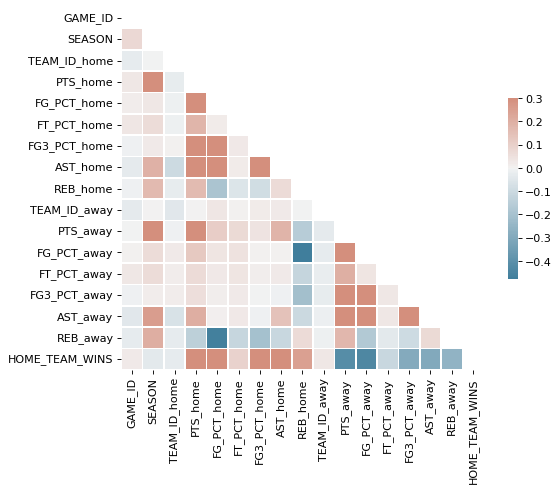

In [10]:
figure(figsize=(8, 6), dpi=80)
corrMatrix = df.corr()

mask = np.triu(np.ones_like(corrMatrix, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [11]:
train_data = df.loc[df['GAME_DATE_EST'] < '2021-05-22'].reset_index(drop=True)

train_data.to_csv('../dataset/train_data.csv', index=False)

/home/silviobaratto/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/silviobaratto/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/silviobaratto/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

Text(0, 0.5, 'Density')

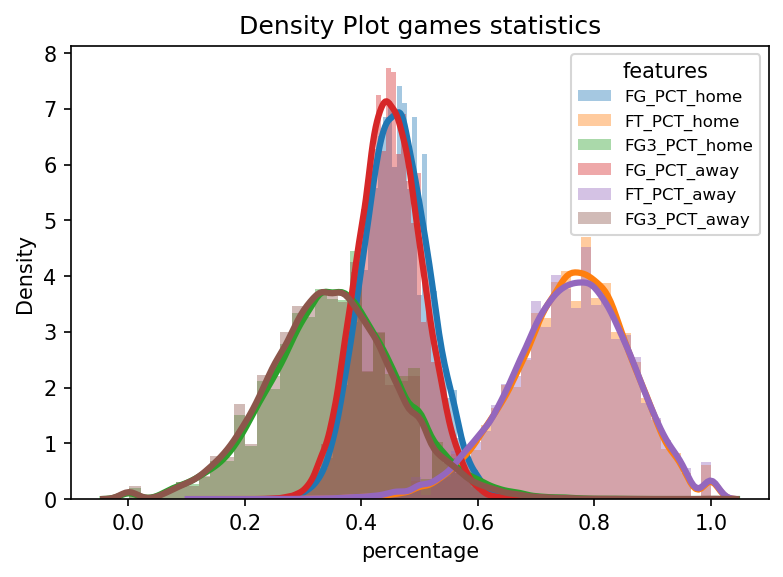

In [47]:
# Iterate through the five airlines
for features in selected_features:
    # Subset to the airline    
    # Draw the density plot
    sns.distplot(train_data[features], hist = True, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = features)
    
# Plot formatting
plt.legend(prop={'size': 8}, title = 'features')
plt.title('Density Plot games statistics')
plt.xlabel('percentage')
plt.ylabel('Density')